# Time-LLM Paper Replicating

In this notebook, we're going to replicate the TimeLLM architecture/paper with PyTorch: https://arxiv.org/abs/2310.01728

To start off, we're first going to build a minimal end-to-end implementation to validate the core workflow. Once that's working, we'll progressively scale up to the full Time-LLM (Llama-7B) architecture as described in the paper.

Workflow:


## 0. Get setup

In [1]:
# Import libraries that are pre-installed in google colab
import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

from typing import List, Tuple, Dict, Callable, Optional

In [2]:
# Install torchinfo
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo, installing it...")
  !pip3 install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo, installing it...


In [3]:
# Setup device agnostic code
def set_device():
  if torch.cuda.is_available():
    device = "cuda"
  elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps"
  else:
    device = "cpu"
  return device

DEVICE = set_device()
print(f"[INFO] Using device: {DEVICE}")

[INFO] Using device: cuda


## 1. Get data

For simplicity, we're going to create a toy dataset.

In [4]:
# For completeness
import numpy as np
import pandas as pd

# Setup periods
PERIODS = 24 * 7 # one day of data

# Create datatime index
dates = pd.date_range("2025-01-01", periods=PERIODS, freq="h")

# Create sine and cos curves as toy data
sin_data = np.sin(np.linspace(0, 2 * np.pi, PERIODS))
cos_data = np.cos(np.linspace(0, 2 * np.pi, PERIODS))

# Create toy dataset
toy_df = pd.DataFrame(
    {"sin_data": sin_data,
     "cos_data": cos_data},
    index=dates
)
toy_df.head()

,sin_data,cos_data
2025-01-01 00:00:00,0.000000,1.000000
2025-01-01 01:00:00,0.037615,0.999292
2025-01-01 02:00:00,0.075177,0.997170
2025-01-01 03:00:00,0.112632,0.993637
2025-01-01 04:00:00,0.149928,0.988697


In [5]:
len(toy_df)

168

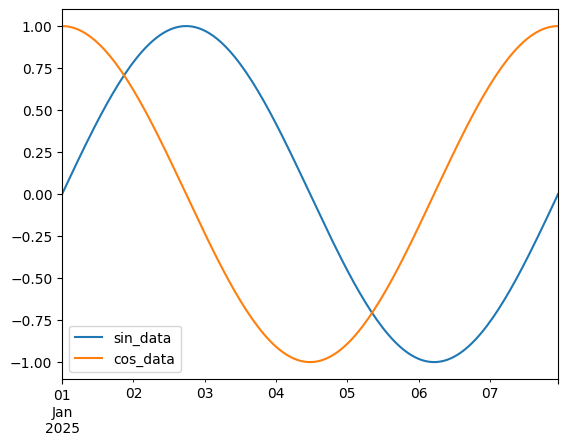

In [6]:
# Visualise data
toy_df.plot();

## 2. Create Datasets and DataLoaders

### 2.1 Split the data into training and test sets

In [7]:
# Let's split the data into training and test sets
train_split = int(len(toy_df) * 0.8)
train_df = toy_df[:train_split]
test_df = toy_df[train_split:]
print(f"[INFO] Size of the training data: {len(train_df)}")
print(f"[INFO] Size of the test data: {len(test_df)}")

[INFO] Size of the training data: 134
[INFO] Size of the test data: 34


### 2.2 Create a custom PyTorch `Dataset` to replicate `TimeSeriesDataset` from PyTorch Forecasting

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`.
2. Init our subclass with our target dataframe, (sliding) window size, forecast horizon, stride as well as a transform if we'd like to apply global transform (e.g. standardization) on our data (not necessary here).
3. Create several attributes:
* df - target dataframe
* window_size - size of the sliding window, also called the history length (number of data points in the past the model uses to predict the future values)
* forecast_horizon - number of steps ahead the model wants to predict in the future
* stride - step size for sliding the input window across the time series
* num_samples - number of training samples
* transform - the (global) transform we'd like to use (not necessary here, just for completeness)
4. Overwrite the `__len__()` method to return the length of our dataset
5. Overwrite the `__getitem__()` method to return a given sample pair (in the form of a `Tuple`, `(input_window, target)`) when passed an index.

**Note:**
- Window size $\neq$ patch size! One input window could correspond to more than one patch!
- The `stride` here is not the same as the stride used in the time series patchification later!
- Given an index, want the `__getitem__()` method to return a tuple `(input_window, target)`
 - `input_window` is a tensor of shape `(number_of_channels, window_size)`
 - `target` is a tensor of shape `(number_of_channels, forcast_horizon)`, where `num_of_channels` means how many time series there are in the dataset.

In [8]:
# Write a custom dataset class and do the import
from torch.utils.data import Dataset
from typing import List, Tuple, Dict, Callable, Optional

# Subclass torch.utils.data.Dataset
class TimeSeriesDatasetCustom(Dataset):
  # Initialize our custom dataset
  def __init__(self,
               df: pd.DataFrame,
               window_size: int,
               forecast_horizon: int = 1,
               stride: int = 1,
               transform: Optional[Callable[[torch.tensor], torch.tensor]] = None): # not necessary, just for completeness
    super().__init__() # optinal here, but doesn't hurt

    # Create class attributes
    self.df = df
    self.window_size = window_size
    self.forecast_horizon = forecast_horizon
    self.stride = stride
    self.transform = transform

  # Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of training samples."
    # Calcuate number of training samples
    num_samples = (len(self.df) - self.window_size - self.forecast_horizon) // self.stride + 1
    return num_samples

  # Overwrite __getitem__() method to return a particular sample pair (input_window, target)
  def __getitem__(self, index: int) -> Tuple[torch.tensor, torch.tensor]:
    "Returns one sample of data, data and label (x, y)."
    start = index * self.stride
    x = self.df[start: start + self.window_size].to_numpy()
    y = self.df[start + self.window_size: start + self.window_size + self.forecast_horizon].to_numpy()

    # Convert X & y to tensors
    x = torch.from_numpy(x).type(torch.float32) # convert the datatype from float64 (Numpy's default dtype) to float32 (PyTorch's default dtype)
    y = torch.from_numpy(y).type(torch.float32)

    # Change the output shape of x (pytorch prefers channel-first)
    if x.ndim == 1: # univariate time series data
      x = x.unsqueeze(dim=0) # add channel size
    else: # multivariate time series data
      x = x.transpose(0, 1) # channel first

    # Change the output shape of y as well
    if y.ndim == 1:
      y = y.unsqueeze(dim=0) # add channel size
    else:
      y = y.transpose(0, 1) # channel first

    # Transform if necessary
    if self.transform:
      return self.transform(x), y
    else:
      return x, y

In [9]:
# Test out TimeSeriesDatasetCustom
train_data_custom = TimeSeriesDatasetCustom(df=train_df,
                                            window_size=5,
                                            stride=5) # non-overlapping window because it is equal to the window size
test_data_custom = TimeSeriesDatasetCustom(df=test_df,
                                           window_size=5,
                                           stride=5)
train_data_custom, test_data_custom

(<__main__.TimeSeriesDatasetCustom at 0x7f6dcb033310>,
 <__main__.TimeSeriesDatasetCustom at 0x7f6ddc04b490>)

In [10]:
# Test out the __len__() method
# Print out some info about our dataset
print(f"[INFO] Size of the training dataset: {len(train_data_custom)}")
print(f"[INFO] Size of the test dataset: {len(test_data_custom)}")

[INFO] Size of the training dataset: 26
[INFO] Size of the test dataset: 6


In [11]:
# Verify the number of samples (size of the dataset - window_size)
len(train_data_custom) == (len(train_df) - 5 - 1) // 5 + 1, len(test_data_custom) == (len(test_df) - 5 - 1) // 5 + 1

(True, True)

In [12]:
# Print some more info to test out the __getitem__() method
dataset_dict = {"training": train_data_custom,
                "test": test_data_custom}

for split, dataset in dataset_dict.items():
  print(f"[INFO] Sample 0 of {split} set:")
  print(f"Data:\n{dataset[0][0]}")
  print(f"Shape: {dataset[0][0].shape}")
  print()
  print(f"Target:\n{dataset[0][1]}")
  print(f"Shape: {dataset[0][1].shape}")
  print("\n")

[INFO] Sample 0 of training set:
Data:
tensor([[0.0000, 0.0376, 0.0752, 0.1126, 0.1499],
        [1.0000, 0.9993, 0.9972, 0.9936, 0.9887]])
Shape: torch.Size([2, 5])

Target:
tensor([[0.1870],
        [0.9824]])
Shape: torch.Size([2, 1])


[INFO] Sample 0 of test set:
Data:
tensor([[-0.9463, -0.9335, -0.9193, -0.9039, -0.8871],
        [ 0.3233,  0.3587,  0.3935,  0.4278,  0.4615]])
Shape: torch.Size([2, 5])

Target:
tensor([[-0.8691],
        [ 0.4946]])
Shape: torch.Size([2, 1])




### 2.2 Turn custom loaded time series data into DataLoader's

In [13]:
import os
from torch.utils.data import DataLoader

# Setup number of workers and batch size
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 3

# Turn the custom pytorch Datasets into DataLoaders
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True,
                                     drop_last=False)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=6,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False, # no need to shuffle the test data
                                    drop_last=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f6dcb00d910>,
 <torch.utils.data.dataloader.DataLoader at 0x7f6ee184bcd0>)

In [14]:
# Print out some information of the custom dataloaders
print(f"[INFO] Train dataloader (custom) has: {len(train_dataloader_custom)} batches of size: {BATCH_SIZE}")
print(f"[INFO] Test dataloader (custom) has: {len(test_dataloader_custom)} batches of size: {BATCH_SIZE}")

[INFO] Train dataloader (custom) has: 9 batches of size: 3
[INFO] Test dataloader (custom) has: 1 batches of size: 3


In [15]:
# Get a sample from the custom train dataloader
input_window, target = next(iter(train_dataloader_custom))
input_window.shape, target.shape

(torch.Size([3, 2, 5]), torch.Size([3, 2, 1]))

## 3. Replicating TimeLLM: Overview

With the dataloader's ready, we can now proceed to replicate TimeLLM's model architecture. Before we start, it's a good practice to think about the **inputs** and **outputs**.

* Inputs - What goes into the model? A pair consisting of:
  * Input window: A segment of the time series with length `window_size`
    * Shape: `(batch_size, num_channels, window_size)`
    * E.g. `(32, 2, 48)` - 32 samples in a batch, 2 time series, window size of 48
  * Target values: The ground truth value we want our model to predict
    * Shape: `(batch_size, num_channels, forecast_horizon)`
    * E.g. `(32, 2, 24)` - 32 samples in a batch, 2 time series, 24 ground truth future values

* Outputs - What comes out of the model?
  * Predictions for future time steps
    * Shape: `(batch_size, forecast_horizon)`
    * E.g. `(32, 24)` - 32 samples in a batch, 24 predictions into the future
  
> Note: The shape of the model outpus doesn't have `num_channels` in the second dimension because our model processes each (univariate) time series subsequently.

### 3.1 TimeLLM overview: pieces of the puzzle

* Figure 2: Visual overview of the architecture
* Figure 3a: Illustration of patch reprogramming
* Figure 3b: Illustration of Patch-as-Prefix vs. Prompt-as-Prefix
* Text (especially section 3.1 - Model Structure)

### Figure 2

  <img src="">